## Window for standard compressed parameters
In this notebook we study how to relate measurements of compressed parameters to the underlying model (in terms of $P^{\theta\theta}$ band powers, Alcock-Paczynski).
See https://www.overleaf.com/2966435843yfhstghbvxxb.

### Define the likelihood of compressed parameters

In [1]:
import numpy as np

from desilike import plotting, setup_logging
from desilike.theories.galaxy_clustering import StandardPowerSpectrumTemplate, DirectPowerSpectrumTemplate, BandVelocityPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable, BoxFootprint, ObservablesCovarianceMatrix
from desilike.likelihoods import ObservablesGaussianLikelihood

setup_logging()

z, b1 = 1., 2.
order = 1

def get_theory(template):
    template.init.update({'only_now': 'peakaverage', 'z': z, 'fiducial': 'DESI'})
    theory = KaiserTracerPowerSpectrumMultipoles(template=template)
    theory.params['b1'].update(fixed=False, value=b1)
    #theory.params['sn0'].update(fixed=True, value=0.)
    return theory

# Fit setup: monopole, quadrupole, hexadecapole between 0.01 and 0.15 h/Mpc
theory_compression = get_theory(template=StandardPowerSpectrumTemplate(apmode='qap'))
observable_compression = TracerPowerSpectrumMultipolesObservable(klim={0: [0.01, 0.15, 0.01], 2: [0.01, 0.15, 0.01], 4: [0.01, 0.15, 0.01]},
                                                                 data={},
                                                                 theory=theory_compression)

footprint = BoxFootprint(volume=1e10, nbar=1e-3)
# Let's compute a Gaussian covariance matrix
covariance = ObservablesCovarianceMatrix(observable_compression, footprints=footprint)()
# The likelihood for our fit setup
likelihood_compression = ObservablesGaussianLikelihood(observables=observable_compression, covariance=covariance)

# Emulate the theory, to make it automatically differentiable
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(theory_compression, engine=TaylorEmulatorEngine(order=order))
emulator.set_samples()
emulator.fit()
# All parameters to be solved analytically
observable_compression.init.update(theory=emulator.to_calculator())
for param in likelihood_compression.varied_params:
    param.update(prior=None, derived='.best')

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))
/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/numpy/lib/polynomial.py:1329: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


[000001.74] [0/1] 03-31 14:40  Emulator                  INFO     Varied parameters: ['qap', 'df', 'b1', 'sn0'].
[000001.75] [0/1] 03-31 14:40  Emulator                  INFO     Found varying ['power'] and fixed ['k', 'ells'] outputs.
[000001.75] [0/1] 03-31 14:40  Differentiation           INFO     Varied parameters: ['qap', 'df', 'b1', 'sn0'].
[000002.06] [0/1] 03-31 14:40  Differentiation           INFO     Using finite-differentiation for parameter qap.
[000002.29] [0/1] 03-31 14:40  Differentiation           INFO     Using auto-differentiation for parameter df.
[000002.34] [0/1] 03-31 14:40  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000002.38] [0/1] 03-31 14:40  Differentiation           INFO     Using auto-differentiation for parameter sn0.
[000002.38] [0/1] 03-31 14:40  Differentiation           INFO     qap grid is [0.998 1.    1.002].


### Estimate window by varying the underlying model  ($P^{\theta\theta}$ + AP) of the data

In [2]:
# Underlying model is band power + AP
kp = np.unique(np.concatenate(observable_compression.k))
template_band = BandVelocityPowerSpectrumTemplate(kp=kp)
theory_band = get_theory(template=template_band)
for param in theory_band.params: param.update(fixed=True)
observable_band = observable_compression.deepcopy()
observable_band.init.update(theory=theory_band)

from desilike.base import BaseCalculator

# This calculator computes best fit compressed parameters, as a function of underlying model
class CompressionWindow(BaseCalculator):

    def initialize(self, likelihood, observable, quantities):
        self.likelihood = likelihood
        self.observable = observable
        self.quantities = quantities
        self.runtime_info.requires = [self.observable]

    def calculate(self):
        self.likelihood.flatdata = self.observable.flattheory.copy()
        for i in range(3):
            self.likelihood()  # find parameter best fit (iteratively in case order > 1)
        #self.likelihood.observables[0].plot(show=True)
        self.values = {}
        for quantity in self.quantities:
            self.values[quantity.name] = self.likelihood.runtime_info.pipeline.param_values[quantity.name]

    def get(self):
        return self.values

    def __getstate__(self):
        state = {'compression_{}'.format(quantity): value for quantity, value in self.values.items()}
        for name in ['quantities']: state[name] = getattr(self, name)
        return state

    def __setstate__(self, state):
        for name in ['quantities']: setattr(self, name, state[name])
        self.values = {quantity.name: state['compression_{}'.format(quantity.name)] for quantity in self.quantities}

        
compression_window = CompressionWindow(likelihood=likelihood_compression, observable=observable_band, quantities=theory_compression.template.varied_params)
emulator = Emulator(compression_window, engine=TaylorEmulatorEngine(order=order))
emulator.set_samples()
emulator.fit()
emulated_compression_window = emulator.to_calculator()

[000003.67] [0/1] 03-31 14:40  Differentiation           INFO     Varied parameters: ['b1', 'sn0', 'qap', 'df'].
[000003.67] [0/1] 03-31 14:40  Differentiation           INFO     Varied parameters: ['b1', 'sn0', 'qap', 'df'].
[000004.72] [0/1] 03-31 14:40  Emulator                  INFO     Varied parameters: ['qap', 'dptt0', 'dptt1', 'dptt2', 'dptt3', 'dptt4', 'dptt5', 'dptt6', 'dptt7', 'dptt8', 'dptt9', 'dptt10', 'dptt11', 'dptt12', 'dptt13'].
[000004.72] [0/1] 03-31 14:40  Emulator                  INFO     Found varying ['pk_tt', 'compression_qap', 'compression_df'] and fixed ['f', 'kp', 'quantities'] outputs.
[000004.72] [0/1] 03-31 14:40  Differentiation           INFO     Varied parameters: ['qap', 'dptt0', 'dptt1', 'dptt2', 'dptt3', 'dptt4', 'dptt5', 'dptt6', 'dptt7', 'dptt8', 'dptt9', 'dptt10', 'dptt11', 'dptt12', 'dptt13'].
[000005.02] [0/1] 03-31 14:40  Differentiation           INFO     Using finite-differentiation for parameter qap.
[000005.20] [0/1] 03-31 14:40  Different

### Let's test our window by fitting w0waCDM models

In [3]:
observable_compression.init.update(theory=theory_compression)
observable_direct = observable_compression.deepcopy()

template_direct = DirectPowerSpectrumTemplate()
theory_direct = get_theory(template=template_direct)
observable_direct.init.update(theory=theory_direct)

from desilike.profilers import MinuitProfiler

profiler = MinuitProfiler(likelihood_compression, seed=42)
bestfits, expected_no_window, expected_no_window_grid, expected_with_window = [], [], [], []

def get_expected_no_window(grid_coordinates=False):
    cosmo, fiducial = template_direct.cosmo, template_direct.fiducial
    r = 8.
    # We should remove wiggles first, but let's neglect their contribution
    fsigma8_fid = fiducial.get_fourier().sigma_rz(r, z=template_direct.z, of='theta_cb')
    qper, qpar = cosmo.comoving_angular_distance(template_direct.z) / fiducial.comoving_angular_distance(template_direct.z), fiducial.efunc(template_direct.z) / cosmo.efunc(template_direct.z)
    qiso = qpar**(1. / 3.) * qper**(2. / 3.)
    qap = qpar / qper
    if grid_coordinates: r *= qiso  # Move r from grid to true coordinates
    df = cosmo.get_fourier().sigma_rz(r, z=template_direct.z, of='theta_cb') / fsigma8_fid
    return {'qiso': qiso, 'qap': qap, 'qpar': qpar, 'qper': qper, 'df': df}

def get_expected_with_window():
    cosmo, fiducial = template_direct.cosmo, template_direct.fiducial
    qper, qpar = cosmo.comoving_angular_distance(template_direct.z) / fiducial.comoving_angular_distance(template_direct.z), fiducial.efunc(template_direct.z) / cosmo.efunc(template_direct.z)
    qiso = qpar**(1. / 3.) * qper**(2. / 3.)
    qap = qpar / qper
    from cosmoprimo import PowerSpectrumBAOFilter
    filter = PowerSpectrumBAOFilter(fiducial.get_fourier().pk_interpolator(of='theta_cb').to_1d(z=template_direct.z), engine='peakaverage', cosmo=fiducial, cosmo_fid=fiducial)
    pk_tt_interpolator_fid = filter.smooth_pk_interpolator()
    filter(cosmo.get_fourier().pk_interpolator(of='theta_cb').to_1d(z=template_direct.z), cosmo=cosmo)
    pk_tt_interpolator = filter.smooth_pk_interpolator()
    pk_tts.append(pk_tt_interpolator)
    # Move pk_tt from grid to true coordinates
    pk_tt = 1. / qiso**3 * pk_tt_interpolator(kp / qiso)
    # Compare to fiducial
    pk_tt /= pk_tt_interpolator_fid(kp)
    params = {'qap': qap, **{'dptt{:d}'.format(ik): ptt for ik, ptt in enumerate(pk_tt)}}
    return emulated_compression_window(**params)

params = {}
params['w0_fld'] = [-1.2, -1., -0.8]
params['wa_fld'] = [-0.3, 0., 0.3]
#params['Omega_m'] = [0.2, 0.3, 0.4]
#params['h'] = [0.65, 0.7, 0.75]
import itertools
grid_params = [dict(zip(params.keys(), values)) for values in itertools.product(*params.values())]
for param in params:
    template_direct.params[param].update(fixed=False)

theories, pk_tts = [], []
for params in grid_params:
    likelihood_compression.flatdata = observable_direct(**params).flattheory
    theories.append(observable_direct.theory)
    profiles = profiler.maximize(niterations=3)
    profiler.profiles = None
    index = profiles.bestfit.logposterior.argmax()
    bestfits.append({param.name: (profiles.bestfit[param][index], profiles.error[param][index]) for param in profiles.bestfit.params(varied=True)})
    expected_no_window.append(get_expected_no_window(grid_coordinates=False))
    expected_no_window_grid.append(get_expected_no_window(grid_coordinates=True))
    expected_with_window.append(get_expected_with_window())
    #print('besfit', bestfits[-1])
    #print('no window', expected_no_window[-1])
    #print('no window grid', expected_no_window_grid[-1])
    #print('with window', expected_with_window[-1])

[000009.25] [0/1] 03-31 14:40  MinuitProfiler            INFO     Varied parameters: ['qap', 'df', 'b1', 'sn0'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:27: UserWarning: EisensteinHuNoWiggleEngine cannot cope with non-constant dark energy
  warnings.warn('{} cannot cope with non-constant dark energy'.format(self.__class__.__name__))


[000051.63] [0/1] 03-31 14:41  Plotting                  INFO     Saving figure to _tests/compression_kaiser_nowiggle.png.


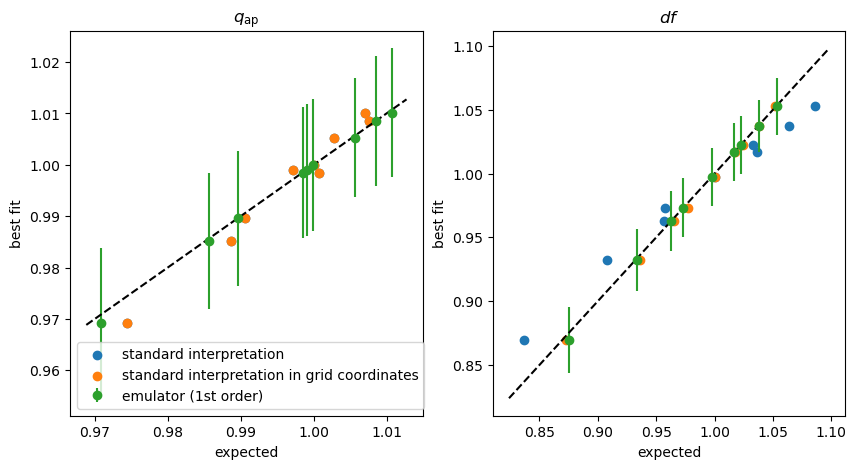

[000052.12] [0/1] 03-31 14:41  Plotting                  INFO     Saving figure to _tests/power_kaiser_nowiggle.png.


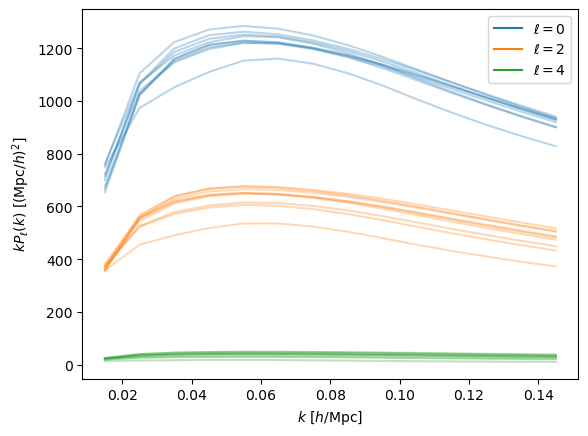

In [4]:
# Plots
params_compression = emulated_compression_window.quantities

from matplotlib import pyplot as plt
fig, lax = plt.subplots(1, len(params_compression), sharex=False, sharey=False, figsize=(len(params_compression) * 5, 5), squeeze=False)
lax = lax.flatten()
fig.subplots_adjust(hspace=0)
for iparam, param in enumerate(params_compression):
    ax = lax[iparam]
    ax.scatter([expected[param.name] for expected in expected_no_window], [bestfit[param.name][0] for bestfit in bestfits], color='C0', label='standard interpretation')
    ax.scatter([expected[param.name] for expected in expected_no_window_grid], [bestfit[param.name][0] for bestfit in bestfits], color='C1', label='standard interpretation in grid coordinates')
    ax.errorbar([expected[param.name] for expected in expected_with_window], [bestfit[param.name][0] for bestfit in bestfits], yerr=[bestfit[param.name][1] for bestfit in bestfits], color='C2', label='emulator (1st order)', marker='o', linestyle='')
    ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='--', color='k')
    ax.set_xlabel('expected')
    ax.set_ylabel('best fit')
    ax.set_title(param.latex(inline=True))
lax[0].legend()
plotting.savefig('_tests/compression_kaiser_nowiggle.png')
plt.show()

ax = plt.gca()
for ill, ell in enumerate(observable_direct.ells):
    for theory in theories:
        ax.plot(observable_direct.k[ill], observable_direct.k[ill] * theory[ill], color='C{:d}'.format(ill), alpha=0.3)
    ax.plot([], [], linestyle='-', color='C{:d}'.format(ill), label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plotting.savefig('_tests/power_kaiser_nowiggle.png')
plt.show()